## Step 1: Install the dependencies scripts and python packages
In order to ran the whole program, you need:
```
    abc             # the compiled abc binary file
    abc.rc          # the alias of abc
    tautology.ipynb # this notebook
```

Besides, make sure your python version is above 3.4

In [12]:
import subprocess
import sys
import random
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
if not os.path.exists('abc'):
    raise EnvironmentError
if not os.path.exists('abc.rc'):
    raise EnvironmentError
if not os.path.exists('results'):
    os.makedirs('results')

## Step 2: Define the function
Do not modify the function below

In [2]:
def print_tautology_blif(input_size, 
                         file = 'test.temp', 
                         shuffle_product = False,
                         shuffle_sum = False):
    '''
    print_tautology_blif:
        1. Generate an tautology logic with <input_size> inputs
        2. Write the result to <file>
        3. Random Shufle the product if <shuffle_product> is True
        4. Random Shufle the sum if <shuffle_sum> is True
    '''
    with open(file,'w') as f:
        f.write('.model test\n')
        f.write('.inputs '+' '.join(['input'+str(index) for index in range(input_size)])+'\n')
        f.write('.outputs out\n')
        # single products in random order
        seq = [*range(2**input_size)]
        if shuffle_product:
            random.shuffle(seq)
        for combination in seq:
            f.write('.names '+' '.join(['input'+str(index) for index in range(input_size)])+' node'+str(combination)+'\n')
            f.write(('{0:0'+str(input_size)+'b}').format(combination)+' 1\n')
        # sum all the products in random order
        if shuffle_sum:
            random.shuffle(seq)
        f.write('.names '+' '.join(['node'+str(index) for index in seq])+' out\n')
        f.write('0'*(2**input_size)+' 0\n')
        f.write('.end\n')
def run_synthesis(file, opt_command='compress2rs'):
    commands = [
        'read_blif {0}'.format(file),
        'strash',
        'ps',
        'write_blif src.temp',
        opt_command,
        'ps',
        'write_blif res.temp'
    ]
    shell_command = './abc -c \"{0}\"'.format(';'.join(commands))
    return subprocess.getoutput(shell_command)
def parse_report(report, verbose = False):
    assert report is not None
    for report_line in report.split('\n'):
        obj = re.match(r'.*and = (.*) lev = (.*)', report_line, re.M|re.I)
        if obj is None:
            continue
        area = int(obj.group(1).strip())
        level = int(obj.group(2).strip())
        if verbose:
            print('area = {0}, level = {1}'.format(area,level))
    return area, level
def clean_results():
    if os.path.exists('res.temp'):
        os.remove('res.temp')
    if os.path.exists('src.temp'):
        os.remove('src.temp')
    if os.path.exists('test.temp'):
        os.remove('test.temp')
def record(bname):
    '''
    store the result of source code
        <bmark>_src.blif: the input
        <bmark>_abc.blif: the result after synthesis of abc
    '''
    subprocess.run('cp src.blif results/{0}_src.blif'.format(bname), shell=True)
    subprocess.run('cp res.blif results/{0}_abc.blif'.format(bname), shell=True)

## Step 3: Run the script

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.35it/s]


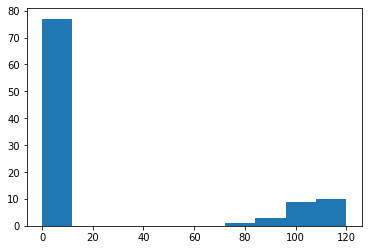

In [16]:
number_episode = 100
area_results = []
for _ in tqdm(range(number_episode), ncols = 80):
    # generate tautology
    print_tautology_blif(input_size = 6,
                        file = 'test.temp',
                        shuffle_product = False,
                        shuffle_sum = True)
    # run synthesis
    report = run_synthesis(file = 'test.temp',
                        opt_command = 'compress2rs')
    # parse the report
    area, level = parse_report(report)

    area_results.append(area)

    # clean the temp files
    clean_results()
plt.hist(area_results)
plt.show()